Using device: cuda
Training Hourglass ResNet model...
Epoch 5/50: train_loss=0.0965, train_acc=97.83%, test_loss=0.0738, test_acc=97.78%
Epoch 10/50: train_loss=0.0582, train_acc=98.42%, test_loss=0.0280, test_acc=99.22%
Epoch 15/50: train_loss=0.0476, train_acc=98.36%, test_loss=0.0240, test_acc=99.44%
Epoch 20/50: train_loss=0.0359, train_acc=98.92%, test_loss=0.0126, test_acc=99.56%
Epoch 25/50: train_loss=0.0433, train_acc=98.61%, test_loss=0.0200, test_acc=99.22%
Epoch 30/50: train_loss=0.0221, train_acc=99.19%, test_loss=0.0192, test_acc=99.22%
Epoch 35/50: train_loss=0.0204, train_acc=99.42%, test_loss=0.0130, test_acc=99.67%
Epoch 40/50: train_loss=0.0187, train_acc=99.36%, test_loss=0.0104, test_acc=99.67%
Epoch 45/50: train_loss=0.0199, train_acc=99.36%, test_loss=0.0131, test_acc=99.44%
Epoch 50/50: train_loss=0.0283, train_acc=98.97%, test_loss=0.0155, test_acc=99.56%


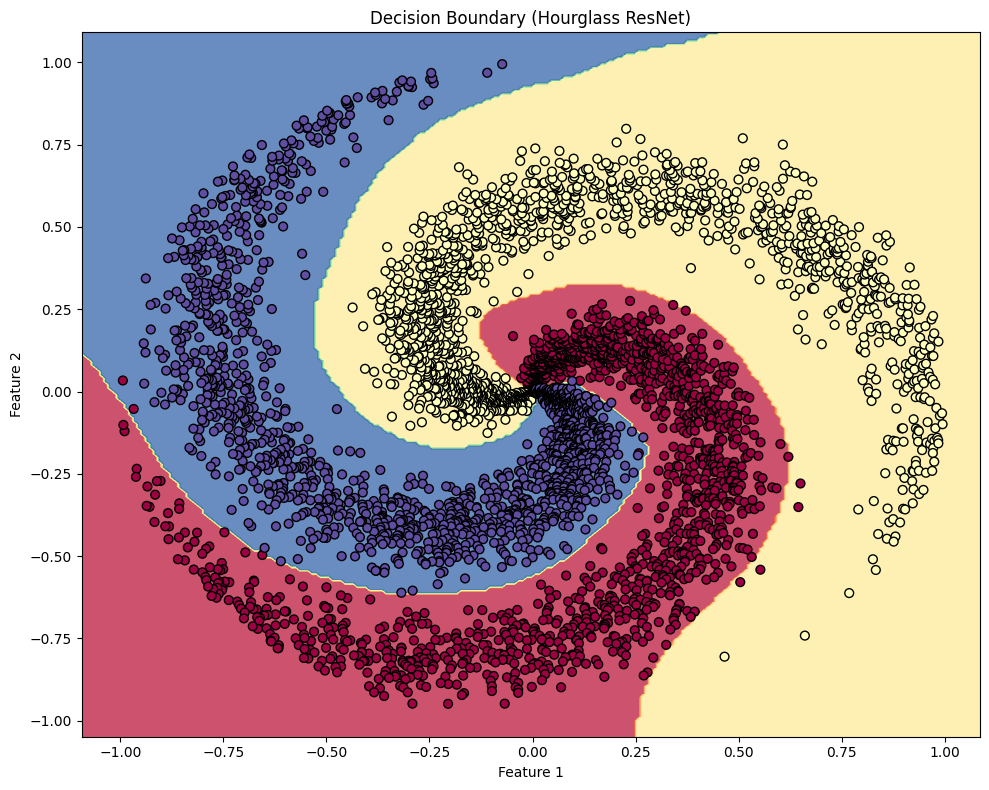

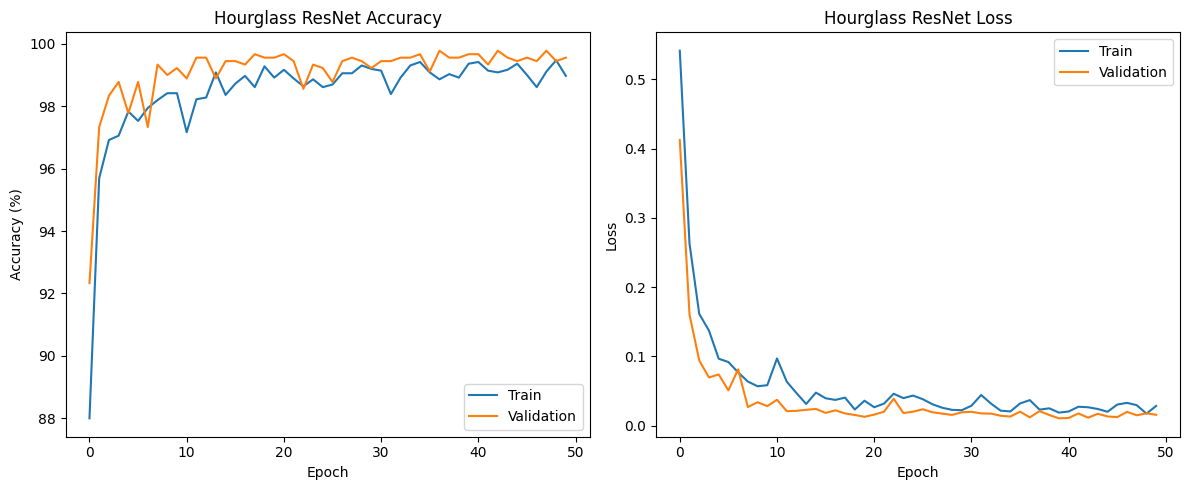

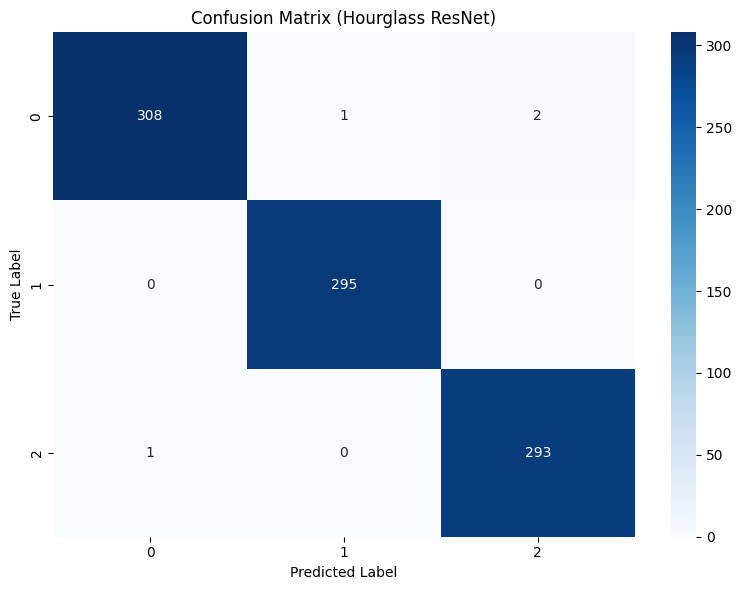

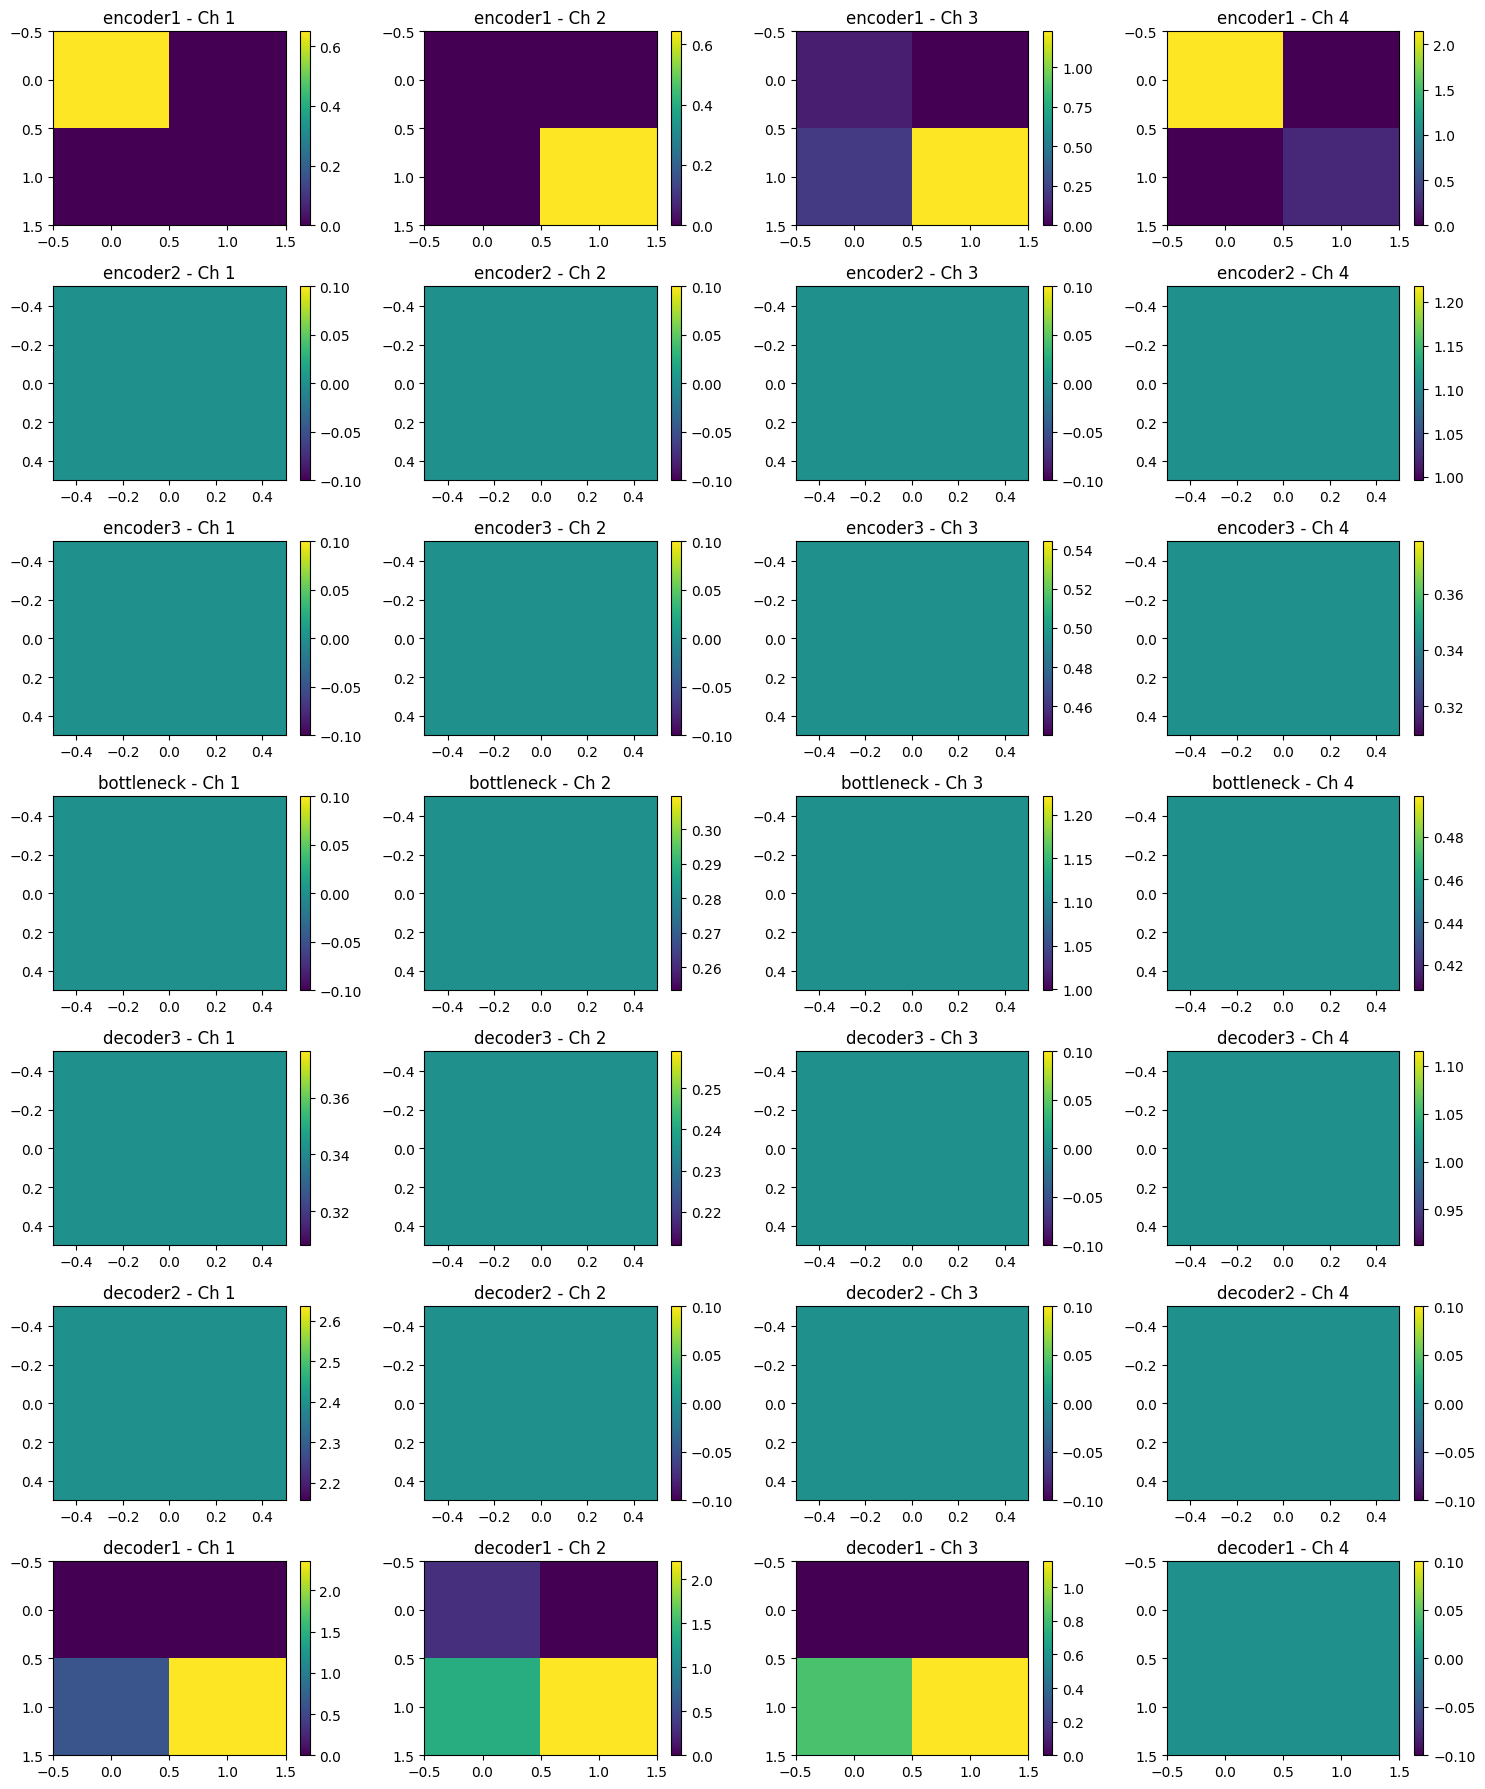

Classification Report (Hourglass ResNet):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       311
           1       1.00      1.00      1.00       295
           2       0.99      1.00      0.99       294

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900


Training Standard ResNet model for comparison...
Epoch 5/50: train_loss=0.0745, train_acc=97.47%, test_loss=0.0597, test_acc=97.78%
Epoch 10/50: train_loss=0.0591, train_acc=98.14%, test_loss=0.0231, test_acc=99.33%
Epoch 15/50: train_loss=0.0550, train_acc=98.42%, test_loss=0.0164, test_acc=99.33%
Epoch 20/50: train_loss=0.0400, train_acc=98.58%, test_loss=0.0136, test_acc=99.67%
Epoch 25/50: train_loss=0.0477, train_acc=98.44%, test_loss=0.0187, test_acc=99.56%
Epoch 30/50: train_loss=0.0292, train_acc=98.92%, test_loss=0.0157, test_acc=99.67%
Epoch 35/50: train_loss=

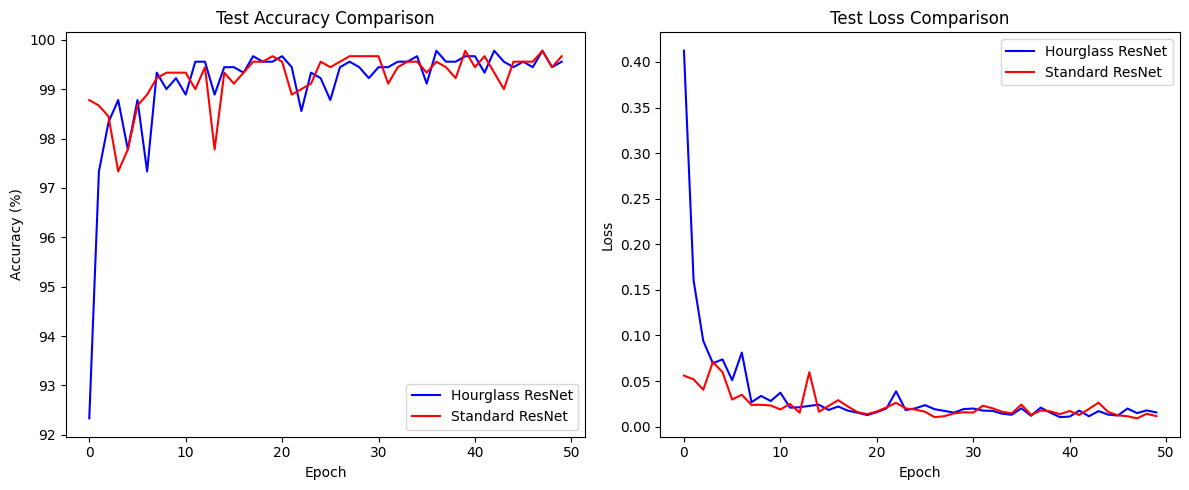


Model Performance Comparison:
Hourglass ResNet final accuracy: 99.56%
Standard ResNet final accuracy: 99.67%
Improvement: -0.11%


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Generate a synthetic dataset
def generate_spiral_data(samples_per_class=1000, classes=3, noise=0.2):
    X = np.zeros((samples_per_class * classes, 2))
    y = np.zeros(samples_per_class * classes, dtype='int64')
    
    for class_idx in range(classes):
        ix = range(samples_per_class * class_idx, samples_per_class * (class_idx + 1))
        r = np.linspace(0.0, 1, samples_per_class)  # radius
        t = np.linspace(class_idx * 4, (class_idx + 1) * 4, samples_per_class) + np.random.randn(samples_per_class) * noise  # theta
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = class_idx
    
    return X, y

# Generate the dataset
X, y = generate_spiral_data(samples_per_class=1500, classes=3, noise=0.3)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create dataset and dataloader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Define Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(residual)
        out = self.relu(out)
        
        return out

# 3. Define UpSample Block with skip connections
class UpSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSampleBlock, self).__init__()
        
        # Upsampling layer
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        # Residual block after concatenation with skip connection
        self.residual = ResidualBlock(out_channels * 2, out_channels)  # *2 for skip connection
    
    def forward(self, x, skip_connection):
        x = self.upsample(x)
        
        # Handle different spatial dimensions if needed
        diff_h = skip_connection.size()[2] - x.size()[2]
        diff_w = skip_connection.size()[3] - x.size()[3]
        
        x = nn.functional.pad(x, [diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2])
        
        # Concatenate along channel dimension
        x = torch.cat([skip_connection, x], dim=1)
        x = self.residual(x)
        
        return x

# 4. Build Hourglass ResNet model
class HourglassResNet(nn.Module):
    def __init__(self, num_classes=3, input_channels=1):
        super(HourglassResNet, self).__init__()
        
        # Initial processing
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        # Encoder (Contracting path)
        self.encoder1 = ResidualBlock(16, 32, stride=1)  # No downsampling for small 2D input
        self.encoder2 = ResidualBlock(32, 64, stride=2)
        self.encoder3 = ResidualBlock(64, 128, stride=2)
        
        # Bottleneck
        self.bottleneck = ResidualBlock(128, 256)
        
        # Decoder (Expanding path)
        self.decoder3 = UpSampleBlock(256, 128)
        self.decoder2 = UpSampleBlock(128, 64)
        self.decoder1 = UpSampleBlock(64, 32)
        
        # Final classification
        self.final_conv = nn.Conv2d(32, 16, kernel_size=1)
        self.final_bn = nn.BatchNorm2d(16)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(16, num_classes)
        
    def forward(self, x):
        # Reshape input to have channel and spatial dimensions
        # For 2D points: (batch_size, 2) -> (batch_size, 1, 2, 2)
        # We duplicate the 2D point to create a tiny 2x2 "image"
        b, d = x.shape
        x = x.view(b, d, 1)
        x = x.repeat(1, 1, 2)
        x = x.unsqueeze(1)
        
        # Initial convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        # Encoder path with skip connections
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        
        # Bottleneck
        b = self.bottleneck(e3)
        
        # Decoder path with skip connections
        d3 = self.decoder3(b, e3)
        d2 = self.decoder2(d3, e2)
        d1 = self.decoder1(d2, e1)
        
        # Final classification
        x = self.final_conv(d1)
        x = self.final_bn(x)
        x = self.relu(x)
        
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

# Initialize the model
model = HourglassResNet(num_classes=3).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    return train_loss, train_acc

# 6. Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Track statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Store predictions and targets for later analysis
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total
    
    return test_loss, test_acc, all_preds, all_targets

# 7. Train the model
epochs = 50
train_losses = []
train_accs = []
test_losses = []
test_accs = []

print("Training Hourglass ResNet model...")
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}: train_loss={train_loss:.4f}, train_acc={train_acc:.2f}%, test_loss={test_loss:.4f}, test_acc={test_acc:.2f}%')

# 8. Final evaluation
_, _, all_preds, all_targets = evaluate(model, test_loader, criterion, device)

# 9. Visualizations
# Decision boundary visualization
def plot_decision_boundary(X, y, model, device):
    h = 0.01  # Step size
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Create tensors from meshgrid
    grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        Z = model(grid_tensor)
        Z = torch.argmax(Z, dim=1).cpu().numpy()
    
    # Reshape back to meshgrid dimensions
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, edgecolors='k', s=40)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title('Decision Boundary (Hourglass ResNet)')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.tight_layout()
    plt.savefig('hourglass_decision_boundary.png')
    plt.show()

# Plot training history
def plot_training_history(train_losses, train_accs, test_losses, test_accs):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_accs)
    plt.plot(test_accs)
    plt.title('Hourglass ResNet Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(train_losses)
    plt.plot(test_losses)
    plt.title('Hourglass ResNet Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.savefig('hourglass_training_history.png')
    plt.show()

# Confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Hourglass ResNet)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('hourglass_confusion_matrix.png')
    plt.show()

# Feature map visualization function
def plot_feature_maps(model, input_sample):
    # Convert to tensor and add batch dimension
    sample = torch.FloatTensor(input_sample).unsqueeze(0).to('cpu')
    
    # Create hooks and storage for feature maps
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach().cpu()
        return hook
    
    # Register hooks
    hooks = []
    # Track encoder activations
    hooks.append(model.encoder1.register_forward_hook(get_activation('encoder1')))
    hooks.append(model.encoder2.register_forward_hook(get_activation('encoder2')))
    hooks.append(model.encoder3.register_forward_hook(get_activation('encoder3')))
    # Track bottleneck
    hooks.append(model.bottleneck.register_forward_hook(get_activation('bottleneck')))
    # Track decoder activations
    hooks.append(model.decoder3.residual.register_forward_hook(get_activation('decoder3')))
    hooks.append(model.decoder2.residual.register_forward_hook(get_activation('decoder2')))
    hooks.append(model.decoder1.residual.register_forward_hook(get_activation('decoder1')))
    
    # Forward pass
    with torch.no_grad():
        model(sample)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Plot activations
    plt.figure(figsize=(15, 18))
    row = 0
    max_channels_to_show = 4
    
    for name, feat in activation.items():
        feat = feat[0]  # Get first item from batch
        num_channels = min(max_channels_to_show, feat.shape[0])
        
        for c in range(num_channels):
            row += 1
            plt.subplot(len(activation), max_channels_to_show, row)
            
            # Handle feature maps of different dimensions
            feat_map = feat[c].numpy()
            if len(feat_map.shape) == 1:
                # For 1D data, reshape to 2D
                size = int(np.sqrt(feat_map.shape[0]))
                if size * size == feat_map.shape[0]:  # Perfect square
                    feat_map = feat_map.reshape(size, size)
                else:
                    # Not a perfect square, just make it a row
                    feat_map = feat_map.reshape(1, -1)
            elif len(feat_map.shape) > 2:
                # For higher dimensions, take the mean
                feat_map = np.mean(feat_map, axis=tuple(range(2, len(feat_map.shape))))
            
            plt.imshow(feat_map, cmap='viridis', aspect='auto')
            plt.title(f"{name} - Ch {c+1}")
            plt.colorbar()
            plt.axis('on')
    
    plt.tight_layout()
    plt.savefig('hourglass_feature_maps.png')
    plt.show()

# 10. Generate all visualizations
# Move model to CPU for visualization
model.to('cpu')

# Decision boundary
plot_decision_boundary(X, y, model, 'cpu')

# Training history
plot_training_history(train_losses, train_accs, test_losses, test_accs)

# Confusion matrix
plot_confusion_matrix(all_targets, all_preds)

# Feature maps
# Get one sample from each class
samples_per_class = []
for class_idx in range(3):
    class_samples = X_test[y_test == class_idx]
    if len(class_samples) > 0:
        samples_per_class.append(class_samples[0])

# Plot feature maps for first sample
if samples_per_class:
    plot_feature_maps(model, samples_per_class[0])

# Print classification report
print("Classification Report (Hourglass ResNet):")
print(classification_report(all_targets, all_preds))


# 11. Compare with standard ResNet
# Build a standard ResNet for comparison
class StandardResNet(nn.Module):
    def __init__(self, num_classes=3):
        super(StandardResNet, self).__init__()
        
        # Initial layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        
        # Residual blocks
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 32),
            ResidualBlock(32, 32)
        )
        
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64, stride=2),
            ResidualBlock(64, 64)
        )
        
        self.layer3 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128)
        )
        
        # Global Average Pooling and classification layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # Reshape input data to have channel dimension
        x = x.view(-1, 1, 2, 1)  # (batch_size, channels, height, width)
        x = x.repeat(1, 1, 1, 2)  # Make it 2x2
        
        # Initial convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        # Residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        # Global average pooling and classification
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

# Train standard ResNet for comparison
std_model = StandardResNet(num_classes=3).to(device)
std_optimizer = optim.Adam(std_model.parameters(), lr=0.001)

std_train_losses = []
std_train_accs = []
std_test_losses = []
std_test_accs = []

print("\nTraining Standard ResNet model for comparison...")
for epoch in range(epochs):
    train_loss, train_acc = train(std_model, train_loader, criterion, std_optimizer, device)
    test_loss, test_acc, _, _ = evaluate(std_model, test_loader, criterion, device)
    
    std_train_losses.append(train_loss)
    std_train_accs.append(train_acc)
    std_test_losses.append(test_loss)
    std_test_accs.append(test_acc)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}: train_loss={train_loss:.4f}, train_acc={train_acc:.2f}%, test_loss={test_loss:.4f}, test_acc={test_acc:.2f}%')

# Final evaluation
_, _, std_preds, std_targets = evaluate(std_model, test_loader, criterion, device)

# 12. Compare models
plt.figure(figsize=(12, 5))

# Compare accuracy
plt.subplot(1, 2, 1)
plt.plot(test_accs, 'b-', label='Hourglass ResNet')
plt.plot(std_test_accs, 'r-', label='Standard ResNet')
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()

# Compare loss
plt.subplot(1, 2, 2)
plt.plot(test_losses, 'b-', label='Hourglass ResNet')
plt.plot(std_test_losses, 'r-', label='Standard ResNet')
plt.title('Test Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

# Print comparison summary
print("\nModel Performance Comparison:")
print(f"Hourglass ResNet final accuracy: {test_accs[-1]:.2f}%")
print(f"Standard ResNet final accuracy: {std_test_accs[-1]:.2f}%")
print(f"Improvement: {test_accs[-1] - std_test_accs[-1]:.2f}%")